### 树模型：以GBDT和XGBOOST为代表
循环预测

0.865 gene MAE

0.838 transplant MAE

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from utils import *
import xgboost as xgb
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor

random.seed(42)

读取数据

In [2]:
# (term_num, time_steps, feature_num)

gene_arr_path = r'../output/gene_editing/es_with_decay.array'
transplant_arr_path = r'../output/transplant/es_with_decay.array'

gene_arr = pickle.load(open(gene_arr_path, mode='rb'))
transplant_arr = pickle.load(open(transplant_arr_path, mode='rb'))

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 17, 10)
Shape of the transplant array: (5141, 17, 10)


### 截断数据
因2019年两个数据集的EmergingScore大部分都为0，而2018年及之前的情况要好很多，故抛弃2019年数据

In [3]:
gene_arr = gene_arr[:, :-1, :]
transplant_arr = transplant_arr[:, :-1, :]

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 16, 10)
Shape of the transplant array: (5141, 16, 10)


### 规范数据并获取训练集和测试集
这里的训练集、测试集和序列模型的不同，是滑动窗口

为了保证可比性，使用位置号来标明原来的序列

因为不是序列模型，所以需要展平多变量序列，也可以使用多个神经网络对每一维进行处理

此外，因为是多变量序列，所以模型要预测所有的变量，不然没法循环输入

https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/

In [4]:
def to_supervised(data, n_inputs, ids_train, ids_test):
    train_data = data[ids_train]
    test_data = data[ids_test]
    
    X_train = list()
    X_test = list()
    y_train = list()
    y_test = list()
    
    for train in train_data:
        for i in range(len(train_data[0]) - n_inputs):
            X_train.append(train[i:i+n_inputs].flatten())
            y_train.append(train[i+n_inputs].flatten())
    
    for test in test_data:
        for i in range(len(test_data[0]) - n_inputs):
            X_test.append(test[i:i+n_inputs].flatten())
            y_test.append(test[i+n_inputs].flatten())
    
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [5]:
def split_data_by_es(data, data_ids):
    # 和RNN的不一样，这里用到ID
    total_es = np.sum(data[data_ids][:, :11, -2], axis=1)
    q75, q25 = np.percentile(total_es, [75 ,25])
    iqr = q75 - q25
    upper_bond = q75 + 1.5 * iqr
    lower_bond = q25 - 1.5 * iqr
    
    data_ids1 = []
    data_ids2 = []
    data_ids3 = []
    data_ids4 = []
    
    for data_id in data_ids:
        cur_es = np.sum(data[data_id][:11, -2])
        if cur_es > upper_bond:
            data_ids1.append(data_id)
        elif q75 < cur_es <= upper_bond:
            data_ids2.append(data_id)
        elif q25 < cur_es <= q75:
            data_ids3.append(data_id)
        elif cur_es <= q25:
            data_ids4.append(data_id)
        else:
            print('error')
    
    return data_ids1, data_ids2, data_ids3, data_ids4

In [6]:
# scaler, data = scale_data(gene_arr, 'standard')
scaler, data = scale_data(transplant_arr, 'standard')
X_train, X_test, y_train, y_test, ids_train, ids_test = split_data_with_index(data, 11, 0.2)

# 如果不是循环预测则不需要执行下面这一行
# X_train, X_test, y_train, y_test = to_supervised(data, 11, ids_train, ids_test)

In [7]:
train_data_ids1, train_data_ids2, train_data_ids3, train_data_ids4 = split_data_by_es(data, ids_train)
test_data_ids1, test_data_ids2, test_data_ids3, test_data_ids4 = split_data_by_es(data, ids_test)

X_train1, X_test1, y_train1, y_test1 = to_supervised(data, 11, train_data_ids1, test_data_ids1)
X_train2, X_test2, y_train2, y_test2 = to_supervised(data, 11, train_data_ids2, test_data_ids2)
X_train3, X_test3, y_train3, y_test3 = to_supervised(data, 11, train_data_ids3, test_data_ids3)
X_train4, X_test4, y_train4, y_test4 = to_supervised(data, 11, train_data_ids4, test_data_ids4)

### 构建模型

训练

In [8]:
train_xs = [X_train1, X_train2, X_train3, X_train4]
train_ys = [y_train1, y_train2, y_train3, y_train4]
test_xs = [X_test1, X_test2, X_test3, X_test4]
test_ys = [y_test1, y_test2, y_test3, y_test4]
i_s = [1, 2, 3, 4]

In [14]:
for train_x, train_y, test_x, test_y, i in zip(train_xs, train_ys, test_xs, test_ys, i_s):
    model = MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=200))
    model.fit(train_x, train_y)
    pickle.dump(model, open(r'tree_model{}.pkl'.format(i), 'wb'))

预测

In [15]:
models = []
for i in range(1, 5):
    models.append(pickle.load(open(r'tree_model{}.pkl'.format(i), 'rb')))

In [16]:
def recursive_predict(model, X_test, n_inputs, n_features, total_timesteps):
    # 只能用每个里面的第一部分，其他用预测来填充
    gap = total_timesteps - n_inputs
    y_pred = []
    i = 0
    while i < len(X_test):
        history = [num for num in X_test[i]]
        i += gap
        inner_pred = []
        for j in range(total_timesteps - n_inputs):
            X = np.array(history[-n_features * n_inputs:]).reshape(1, n_features * n_inputs)
            pred = list(model.predict(X)[0])
            inner_pred.append(pred[-2])
            history += pred
        y_pred.append(np.array(inner_pred))
    return np.array(y_pred)

In [17]:
y_preds = []
y_tests = []
for i in range(len(models)):
    y_preds.append(recursive_predict(models[i], test_xs[i], 11, 10, 16))
    y_tests.append(test_ys[i][:, -2].reshape(len(test_ys[i]) // 5, -1))
y_pred = np.concatenate(y_preds)
y_test = np.concatenate(y_tests)

画图

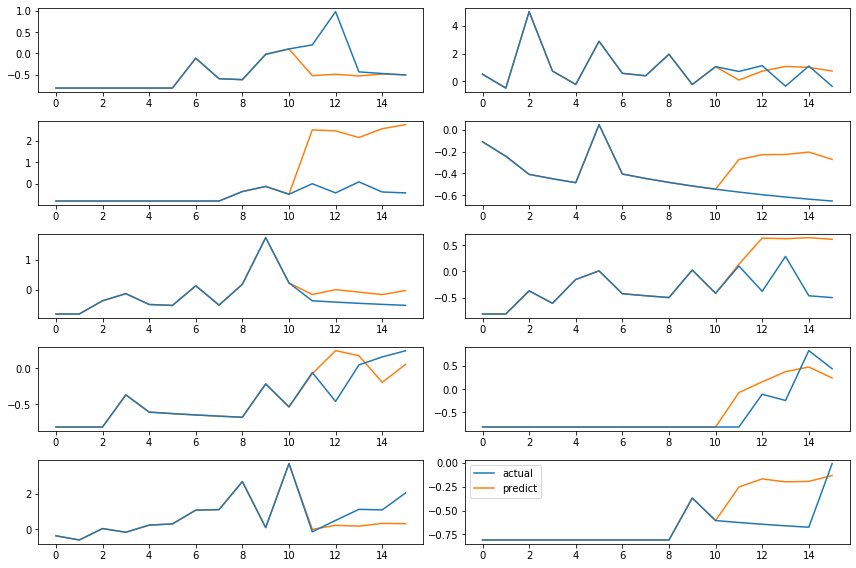

In [17]:
# 训练集
ids = random.sample(range(len(y_test)), 10)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.concatenate((X_train[ids[i], :, -2], y_train[ids[i]].reshape(-1)), axis=None), label='actual', zorder=1)
    plt.plot(np.concatenate((X_train[ids[i], :, -2], y_pred[ids[i]].reshape(-1)), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

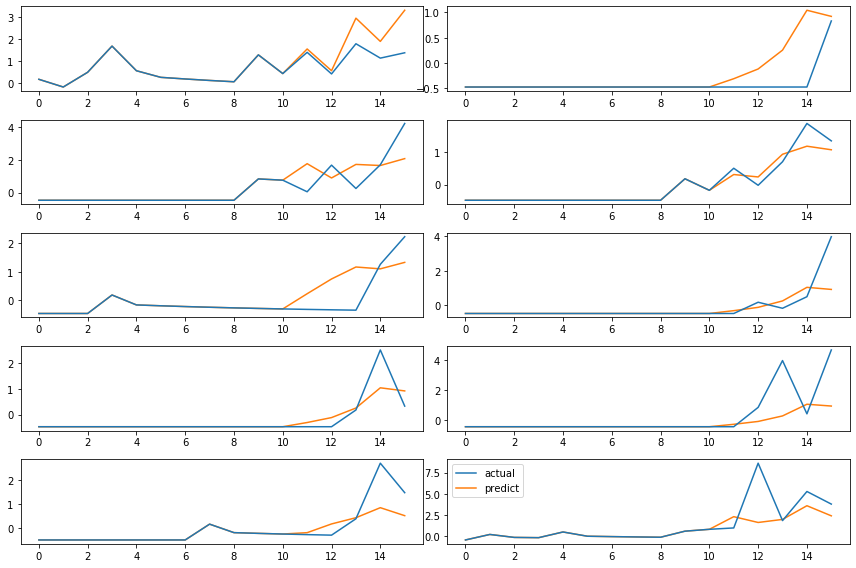

In [33]:
# 测试集
ids = random.sample(range(len(y_test)), 10)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.concatenate((X_test[ids[i], :, -2], y_test[ids[i]].reshape(-1)), axis=None), label='actual', zorder=1)
    plt.plot(np.concatenate((X_test[ids[i], :, -2], y_pred[ids[i]].reshape(-1)), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

评估

MAE: 0.8414343147049227
MAEMAE: [0.73481694 0.81786801 0.8735196  0.85482774 0.92613928]


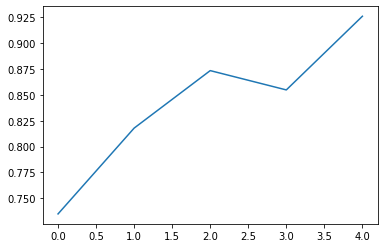

NDCG: 0.31202356661034086
NDCGMAE: [0.6578515556943987, 0.0011939892578318031, 0.0625656279468934, 0.043154449471052965, 0.12623910303244476]


C:\Users\Tom Leung\OneDrive\文件\武汉大学\硕士投稿\主题热度预测\program\utils.py:36: RuntimeWarning: invalid value encountered in true_divide
  pred_score = np.sum((2 ** pred_array[:, 1] - 1) / np.log2(pred_array[:, 0] + 1))


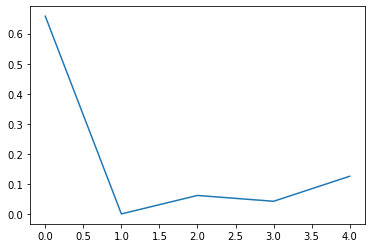

RMSE: 1.2139845418160082
RMSEMAE: [1.07423323 1.24518779 1.25855864 1.2099289  1.27138699]


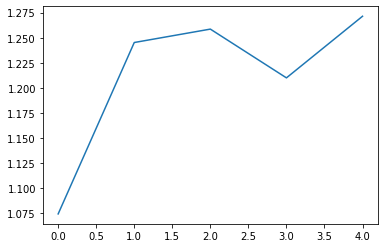

In [18]:
metrics = ['mae', 'ndcg', 'rmse']

for m in metrics:
    overall, annual = eval_model(m, y_test, y_pred, scaler)
    print('{}:'.format(m.upper()), overall)
    print('{}MAE:'.format(m.upper()),annual)
    plt.plot(annual)
    plt.show()

In [18]:
_y_true, _y_pred = eval_model('classification', y_test, y_pred, scaler)

In [19]:
from sklearn.metrics import classification_report
print(classification_report(_y_true.reshape(-1), _y_pred.reshape(-1)))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        27
         1.0       0.70      0.77      0.73      3248
         2.0       0.28      0.15      0.20      1059
         3.0       0.25      0.06      0.09       548
         4.0       0.13      0.42      0.20       263

    accuracy                           0.55      5145
   macro avg       0.27      0.28      0.25      5145
weighted avg       0.53      0.55      0.52      5145



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
